# Seattle Traffic Collisions
Author: Miguel Enrique Játiva Jiménez

# Table of contents
1. [Introduction](#introduction)
2. [Data Wrangling](#data-wrangling)
3. [Data Visualization](#data-visualization)
3. [Pre-processing](#pre-processing)
3. [Modeling](#modeling)
    1. [Decision Tree](#decision-tree)
    1. [K Nearest Neighbors](#kNN)
    1. [Logistic Regression](#LR)
3. [Model Evaluation](#model-evaluation)
    1. [Decision Tree](#decision-tree-eval)
    1. [K Nearest Neighbors](#kNN-eval)
    1. [Logistic Regression](#LR-eval)
3. [Summary](#summary)



## 1. Introduction <a name="introduction"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import itertools
%matplotlib inline 

In [2]:
#Create a directory to save plots
! mkdir plots

A subdirectory or file plots already exists.


In [3]:
# Set the seed
seed = 27912
np.random.seed(seed)

In [4]:
#Read data set
df = pd.read_csv("Data-Collisions.csv")

C:\Users\namas\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


We can have a look to the shape of our dataframe:

In [6]:
df.shape

(194673, 38)

As we can see there are 194673 rows of data and 38 columns.

## 2. Data Wrangling <a name="data-wrangling"></a>

It is seen that there are some columns with missing values. I am going to count missing values in each column (take into account that "True" represents a missing value):

In [7]:
missing_data = df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64

X
False    189339
True       5334
Name: X, dtype: int64

Y
False    189339
True       5334
Name: Y, dtype: int64

OBJECTID
False    194673
Name: OBJECTID, dtype: int64

INCKEY
False    194673
Name: INCKEY, dtype: int64

COLDETKEY
False    194673
Name: COLDETKEY, dtype: int64

REPORTNO
False    194673
Name: REPORTNO, dtype: int64

STATUS
False    194673
Name: STATUS, dtype: int64

ADDRTYPE
False    192747
True       1926
Name: ADDRTYPE, dtype: int64

INTKEY
True     129603
False     65070
Name: INTKEY, dtype: int64

LOCATION
False    191996
True       2677
Name: LOCATION, dtype: int64

EXCEPTRSNCODE
True     109862
False     84811
Name: EXCEPTRSNCODE, dtype: int64

EXCEPTRSNDESC
True     189035
False      5638
Name: EXCEPTRSNDESC, dtype: int64

SEVERITYCODE.1
False    194673
Name: SEVERITYCODE.1, dtype: int64

SEVERITYDESC
False    194673
Name: SEVERITYDESC, dtype: int64

COLLISIONTYPE
False    189769
True       4904
Name: C

Based on the summary above, there are 19 columns with missing values:

* `X`: 5334 missing data
* `Y`: 5334 missing data
* `ADDRTYPE`: 1926 missing data
* `INTKEY`: 129603 missing data
* `LOCATION`: 2677 missing data
* `EXCEPTRSNCODE`: 109862 missing data
* `EXCEPTRSNDESC`: 189035 missing data
* `COLLISIONTYPE`: 4904 missing data
* `JUNCTIONTYPE`: 6329 missing data
* `INATTENTIONIND`: 164868 missing data
* `UNDERINFL`: 4884 missing data
* `WEATHER`: 5081 missing data
* `ROADCOND`: 5012 missing data
* `LIGHTCOND`: 5170 missing data
* `PEDROWNOTGRNT`: 190006 missing data
* `SDOTCOLNUM`: 79737 missing data
* `SPEEDING`: 185340 missing data
* `ST_COLCODE`: 18 missing data
* `ST_COLDESC`: 4904 missing data

Once the summary is printed it is time to decide how should we deal with these missing values. There are several options to be used depending on the situation.

**Replace by frequency:**
* `ADDRTYPE`: 1926 missing values. Looking at the Metadata document we can see that this variable has 3 unique values (Alley, Block, Intersection) so we are going to replace the missing values with the most frequent one
* `COLLISIONTYPE`: 4904 missing values. We are going to replace the missing values with the most frequent Collision Type
* `JUNCTIONTYPE`: 6329 missing values (the reason is the same as the previous one)
* `UNDERINFL`: 4884 missing values (the reason is the same as the previous one)
* `WEATHER`: 5081 missing values (the reason is the same as the previous one)
* `ROADCOND`: 5012 missing values (the reason is the same as the previous one)
* `LIGHTCOND`: 5170 missing values

**Drop the whole column:**
* `INTKEY`: there are 129603 missing values and in our dataframe there are in total 194673 rows, therefore more than half of the values are missing 
* `EXCEPTRSNCODE`: 109862 missing values.
* `EXCEPTRSNDESC`: 189035 missing values.
* `INATTENTIONIND`: 164868 missing values.
* `PEDROWNOTGRNT`: 190006 missing values.
* `SPEEDING`: 185340 missing values.
* `SDOTCOLNUM`: 79737 missing values.
* `LOCATION`: 2677 missing values. We are going to drop this column because its values may be redundant with the columns `X` and `Y` which are the coordinates of the collision.


Let's start by replacing the missing values with the most frequent one:

This method gives us the count of each unique value so we can see which one is the most frequent.

In [8]:
df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

If we use the *idxmax()* method along with *value_counts()* we get the most frequent value directly.

In [9]:
df['ADDRTYPE'].value_counts().idxmax()

'Block'

In [10]:
#replace the missing 'ADDRTYPE' values by the most frequent 
df['ADDRTYPE'].replace(np.nan, 'Block', inplace=True)

In [11]:
df['ADDRTYPE'].value_counts()

Block           128852
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

We can see the changes where applied since there are more samples with the "Block" value on the ADDRTYPE variable. Let's apply the same methodology to the rest of the columns on the list.

In [12]:
#replace the missing 'COLLISIONTYPE' values by the most frequent
most_freq = df['COLLISIONTYPE'].value_counts().idxmax()
df['COLLISIONTYPE'].replace(np.nan, most_freq, inplace=True)

In [13]:
#replace the missing 'JUNCTIONTYPE' values by the most frequent
most_freq = df['JUNCTIONTYPE'].value_counts().idxmax()
df['JUNCTIONTYPE'].replace(np.nan, most_freq, inplace=True)

In [14]:
#replace the missing 'UNDERINFL' values by the most frequent
most_freq = df['UNDERINFL'].value_counts().idxmax()
df['UNDERINFL'].replace(np.nan, most_freq, inplace=True)

In [15]:
#replace the missing 'WEATHER' values by the most frequent
most_freq = df['WEATHER'].value_counts().idxmax()
df['WEATHER'].replace(np.nan, most_freq, inplace=True)

In [16]:
#replace the missing 'ROADCOND' values by the most frequent
most_freq = df['ROADCOND'].value_counts().idxmax()
df['ROADCOND'].replace(np.nan, most_freq, inplace=True)

In [17]:
#replace the missing 'LIGHTCOND' values by the most frequent
most_freq = df['LIGHTCOND'].value_counts().idxmax()
df['LIGHTCOND'].replace(np.nan, most_freq, inplace=True)

After that, let's take care of the columns to be dropped:

In [18]:
#drop the columns listed above
df.drop(['INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','INATTENTIONIND','PEDROWNOTGRNT','SPEEDING','SDOTCOLNUM','LOCATION'], axis=1, inplace=True)

Let's have a look at the columns left:

In [19]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [20]:
df.shape

(194673, 30)

We can see that there are two columns with almost the same name. These are `SEVERITYCODE` and `SEVERITYCODE.1`. So let's check if both are equal:

In [21]:
df['SEVERITYCODE'].equals(df['SEVERITYCODE.1'])

True

Since they are equal we are going to drop one of them:

In [22]:
to_drop = ['SEVERITYCODE.1']

There are some columns that seem to have unique values for each row:

* `OBJECTID`
* `INCKEY`
* `COLDETKEY`
* `REPORTNO`
* `SDOT_COLCODE`
* `ST_COLCODE`
* `SEGLANEKEY`
* `CROSSWALKKEY`

Let's study them.

In [23]:
to_study = ['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'SDOT_COLCODE', 'ST_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY']

for column in to_study:
    print(column + ": {}".format(len(df[column].unique())))

OBJECTID: 194673
INCKEY: 194673
COLDETKEY: 194673
REPORTNO: 194670
SDOT_COLCODE: 39
ST_COLCODE: 116
SEGLANEKEY: 1955
CROSSWALKKEY: 2198


Let's remember that our dataframe has **194673** rows. Looking at the output we can see that `OBJECTID`, `INCKEY`, `COLDETKEY` and `REPORTNO` have the same number of unique values as rows in the dataframe, therefore these variables do not add valuable information to the prediction.

In [24]:
to_drop.extend(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO'])

Let's study now some variables that seem to be descriptions:

* `SEVERITYDESC`
* `SDOT_COLDESC`
* `ST_COLDESC`

Let's study them along with the corresponding "code" column:

In [25]:
df[['SEVERITYCODE','SEVERITYDESC']].value_counts()

SEVERITYCODE  SEVERITYDESC                  
1             Property Damage Only Collision    136485
2             Injury Collision                   58188
dtype: int64

In [26]:
df[['SDOT_COLCODE','SDOT_COLDESC']].value_counts(sort=False)

SDOT_COLCODE  SDOT_COLDESC                                                
0             NOT ENOUGH INFORMATION / NOT APPLICABLE                          9787
11            MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE          85209
12            MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE          1440
13            MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE           5852
14            MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                    54299
15            MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE         1604
16            MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE          9928
18            MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE            3104
21            MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END                       181
22            MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE SIDESWIPE            17
23            MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SIDESWIPE            124
2

In [27]:
df[['ST_COLCODE','ST_COLDESC']].value_counts(sort=False)

ST_COLCODE  ST_COLDESC                                                    
0           Vehicle going straight hits pedestrian                            887
1           Vehicle turning right hits pedestrian                             386
2           Vehicle turning left hits pedestrian                              637
3           Vehicle backing hits pedestrian                                    88
4           Vehicle hits Pedestrian - All Other Actions                        20
                                                                             ... 
83          Same direction -- both turning left -- both moving -- rear end     65
84          Same direction -- both turning left -- one stopped -- rear end     60
85          Vehicle Strikes Deer                                                1
87          Vehicle Strikes All Other Non-Domestic Animal                       1
88          All Other Multi Vehicle                                             8
Length: 114, dtype: int

We can see that each code has a unique description, therefore the code columns already give us the required information so we can drop the description columns. 

*IMPORTANT: These columns could be useful for visualization purposes but in this case I have decided to drop them.*

In [28]:
to_drop.extend(['SEVERITYDESC','SDOT_COLDESC','ST_COLDESC'])

Let's study the columns regarding the date and time:

* `INCDATE`
* `INCDTTM`

In [29]:
df[['INCDATE','INCDTTM']].sample(5)

,INCDATE,INCDTTM
1436,2012/03/10 00:00:00+00,3/10/2012 5:45:00 PM
152520,2016/01/10 00:00:00+00,1/10/2016 5:36:00 AM
82437,2009/10/16 00:00:00+00,10/16/2009 9:00:00 PM
129356,2013/08/19 00:00:00+00,8/19/2013 10:00:00 AM
171504,2017/09/12 00:00:00+00,9/12/2017


We can see that both columns give us the same information but `INCDTTM` also stores the time of the collision so we are going to drop `INCDATE`.

In [30]:
to_drop.extend(['INCDATE'])

In [31]:
df.drop(to_drop, axis=1, inplace=True)

In [32]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'STATUS', 'ADDRTYPE', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM',
       'JUNCTIONTYPE', 'SDOT_COLCODE', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'ST_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR'],
      dtype='object')

In [33]:
df.dtypes

SEVERITYCODE       int64
X                float64
Y                float64
STATUS            object
ADDRTYPE          object
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
INCDTTM           object
JUNCTIONTYPE      object
SDOT_COLCODE       int64
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
ST_COLCODE        object
SEGLANEKEY         int64
CROSSWALKKEY       int64
HITPARKEDCAR      object
dtype: object

Let's study the columns that are more likely to be categories:
* `SEVERITYCODE`
* `STATUS`
* `ADRRTYPE`
* `COLLISIONTYPE`
* `JUNCTIONTYPE`
* `UNDERINFL`
* `WEATHER`
* `ROADCOND`
* `LIGHTCOND`
* `HITPARKEDCAR`

Let's see the distribution of the `SEVERITYCODE` column:

In [34]:
df[['SEVERITYCODE']].value_counts()

SEVERITYCODE
1               136485
2                58188
dtype: int64

Let's see the distribution of the `STATUS` column:

In [35]:
df[['STATUS']].value_counts()

STATUS   
Matched      189786
Unmatched      4887
dtype: int64

Let's see the distribution of the `ADDRTYPE` column:

In [36]:
df[['ADDRTYPE']].value_counts()

ADDRTYPE    
Block           128852
Intersection     65070
Alley              751
dtype: int64

Let's see the distribution of the `COLLISIONTYPE` column:

In [37]:
df[['COLLISIONTYPE']].value_counts()

COLLISIONTYPE
Parked Car       52891
Angles           34674
Rear Ended       34090
Other            23703
Sideswipe        18609
Left Turn        13703
Pedestrian        6608
Cycles            5415
Right Turn        2956
Head On           2024
dtype: int64

Let's see the distribution of the `JUNCTIONTYPE` column:

In [38]:
df[['JUNCTIONTYPE']].value_counts()

JUNCTIONTYPE                                     
Mid-Block (not related to intersection)              96129
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
dtype: int64

We can see that there is a value named **Unknown**. Let's change them with the most frequent value: 

In [39]:
#replace the missing 'JUNCTIONTYPE' values by the most frequent
most_freq = df['JUNCTIONTYPE'].value_counts().idxmax()
df['JUNCTIONTYPE'].replace('Unknown', most_freq, inplace=True)

Let's see the distribution of the `UNDERINFL` column:

In [40]:
df[['UNDERINFL']].value_counts()

UNDERINFL
N            105158
0             80394
Y              5126
1              3995
dtype: int64

We can see that there are four unique values but we only need two of them to represent yes or no. So we are going to convert **0 to N** and **1 to Y**.

In [41]:
df.loc[df.UNDERINFL == '0', 'UNDERINFL'] = "N"
df.loc[df.UNDERINFL == '1', 'UNDERINFL'] = "Y"

In [42]:
df[['UNDERINFL']].value_counts()

UNDERINFL
N            185552
Y              9121
dtype: int64

Let's see the distribution of the `WEATHER` column:

In [43]:
df[['WEATHER']].value_counts()

WEATHER                 
Clear                       116216
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
dtype: int64

Here we can also see the **Unknown** value, we are going to do the same:

In [44]:
#replace the missing 'WEATHER' values by the most frequent
most_freq = df['WEATHER'].value_counts().idxmax()
df['WEATHER'].replace('Unknown', most_freq, inplace=True)

Let's see the distribution of the `ROADCOND` column:

In [45]:
df[['ROADCOND']].value_counts()

ROADCOND      
Dry               129522
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
dtype: int64

In [46]:
#replace the missing 'ROADCOND' values by the most frequent
most_freq = df['ROADCOND'].value_counts().idxmax()
df['ROADCOND'].replace('Unknown', most_freq, inplace=True)

Let's see the distribution of the `LIGHTCOND` column:

In [47]:
df[['LIGHTCOND']].value_counts()

LIGHTCOND               
Daylight                    121307
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
dtype: int64

In [48]:
#replace the missing 'LIGHTCOND' values by the most frequent
most_freq = df['LIGHTCOND'].value_counts().idxmax()
df['LIGHTCOND'].replace('Unknown', most_freq, inplace=True)

Let's see the distribution of the `HITPARKEDCAR` column:

In [49]:
df[['HITPARKEDCAR']].value_counts()

HITPARKEDCAR
N               187457
Y                 7216
dtype: int64

Let's change the type of some columns:

In [50]:
to_cat = ['SEVERITYCODE', 'STATUS', 'ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'HITPARKEDCAR']

In [51]:
df[to_cat] = df[to_cat].astype('category') 
df[['SDOT_COLCODE']] = df[['SDOT_COLCODE']].astype('object')
df[['INCDTTM']] = df[['INCDTTM']].astype('datetime64')

In [52]:
df.dtypes

SEVERITYCODE           category
X                       float64
Y                       float64
STATUS                 category
ADDRTYPE               category
COLLISIONTYPE          category
PERSONCOUNT               int64
PEDCOUNT                  int64
PEDCYLCOUNT               int64
VEHCOUNT                  int64
INCDTTM          datetime64[ns]
JUNCTIONTYPE           category
SDOT_COLCODE             object
UNDERINFL              category
WEATHER                category
ROADCOND               category
LIGHTCOND              category
ST_COLCODE               object
SEGLANEKEY                int64
CROSSWALKKEY              int64
HITPARKEDCAR           category
dtype: object

Let's check if there are any columns left with NaN values:

In [53]:
df.columns[df.isna().any()].tolist()

['X', 'Y', 'ST_COLCODE']

We can see that `ST_COLCODE` has some missing values, we are going to drop it because the column `SDOT_COLCODE` gives us almost the same information. Regarding the `X` and `Y` columns we are going to use them for visualization purposes and after that they will be dropped.

In [54]:
df.drop(['ST_COLCODE'], axis=1, inplace=True)

Let's now split the dataset into train and test.

In [55]:
# Split the dataset in training and test
(df, df_test) = train_test_split(
    df,
    train_size=0.7, shuffle=True, random_state=seed)

## 3. Data Visualization <a name="data-visualization"></a>

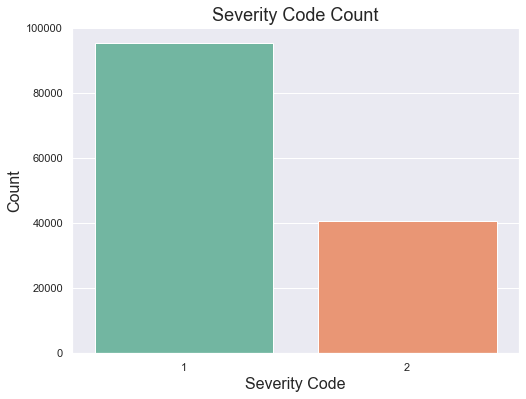

In [56]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8,6))
sns.countplot(x ='SEVERITYCODE', palette='Set2', data = df) 
plt.title('Severity Code Count', fontsize=18)
plt.xlabel('Severity Code', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('./plots/1.png')

In [57]:
df["SEVERITYCODE"].value_counts(normalize=True)*100

1    70.117633
2    29.882367
Name: SEVERITYCODE, dtype: float64

We can see that the data is not balanced 70% of the collisions are type 1 which means prop damage, and 30% type 2 injury.

Let's see how the number of collisions has evolved through the years.

C:\Users\namas\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


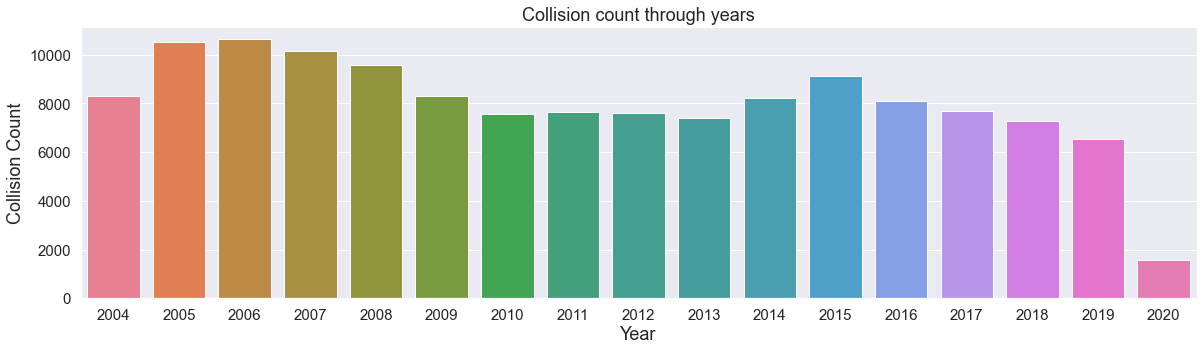

In [58]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(df['INCDTTM'].dt.year, palette='husl', ax=ax)
ax.set_xlabel('Year', fontsize=18)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Collision Count', fontsize=18)
plt.title('Collision count through years', fontsize=18)
plt.savefig('./plots/2.png')

We can see that the number of collisions have been decreasing since 2015. We can also see that there is a small amount of collisions in 2020, this is probably due to the pandamic situation we are living. 

After that, let's study the amount of collisions throughout the day. To do that, let's extract the hour from the `INCDTTM` column:

In [59]:
df['HOUR'] = df['INCDTTM'].dt.hour

In [60]:
df[['HOUR', 'INCDTTM']].sample(5)

,HOUR,INCDTTM
188006,5,2018-11-06 05:09:00
182541,14,2019-10-11 14:05:00
191989,16,2019-08-19 16:59:00
65097,18,2008-07-23 18:30:00
89599,20,2010-11-22 20:25:00


Now, let's create a label for each time of the day:

In [61]:
bins = [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df['TIME'] = pd.cut(df['HOUR'], bins=bins, labels=labels, include_lowest=True)

In [62]:
df[['TIME','HOUR']].sample(5)

,TIME,HOUR
140558,Morning,11
63537,Noon,14
102916,Morning,12
139095,Late Night,0
110700,Early Morning,7


Once everything is checked we can drop the `HOUR` column created earlier:

In [63]:
df.drop(['HOUR'], axis=1, inplace=True)

Now we can plot the amount of collisions given the time of the day:

In [64]:
def time_of_day_plot(df, title):
    '''
    Creates a countplot visualizing the data throughout the day 
    including the frequency.
    
        Parameters:
            df(DataFrame): Data to be visualized
            title(str): Title for the plot
    '''
    ncount = len(df['TIME'])
    plt.figure(figsize=(12,8))
    ax = sns.countplot(x='TIME', palette='flare', data=df)
    plt.title(title, fontsize=18)
    plt.xlabel('Time of the day', fontsize=18)

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax.set_ylabel('Count', fontsize=18)
    ax2.set_ylabel('Frequency [%]', fontsize=18)
    ax.tick_params(axis="x", labelsize=15)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom', fontsize=15) # set the alignment of the text

    ax2.set_ylim(0,100*ax.get_ylim()[1]/ncount)

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

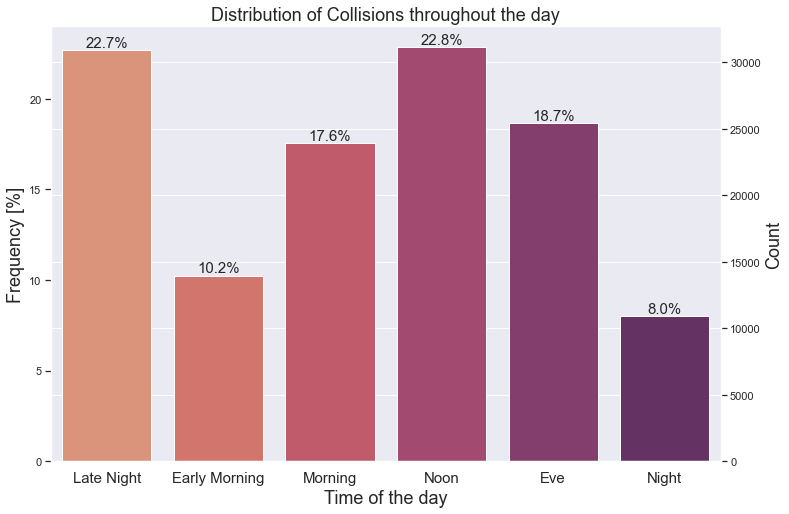

In [65]:
time_of_day_plot(df, 'Distribution of Collisions throughout the day')
plt.savefig('./plots/3.png')

It is clearly seen that the time of the day when most collisions occur are **Late Night** and **Noon**.

Let's now study how the influence of alcohol and drugs affects collisions.

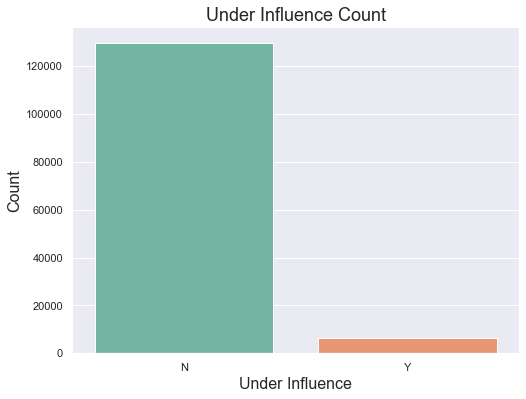

In [66]:
plt.figure(figsize=(8,6))
sns.countplot(x ='UNDERINFL', palette='Set2', data = df) 
plt.title('Under Influence Count', fontsize=18)
plt.xlabel('Under Influence', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('./plots/4.png')

We see that in the majority of the collisions that occur, the drivers where not under the influence of alcohol/drugs. Let's now see the distribution of collisions inlfuenced by alcohol/drugs throughout the day: 

In [67]:
#Filter the dataset with only the rows where UNDERINFL is Y
influenced = df['UNDERINFL'] == 'Y'
influenced = df[influenced]

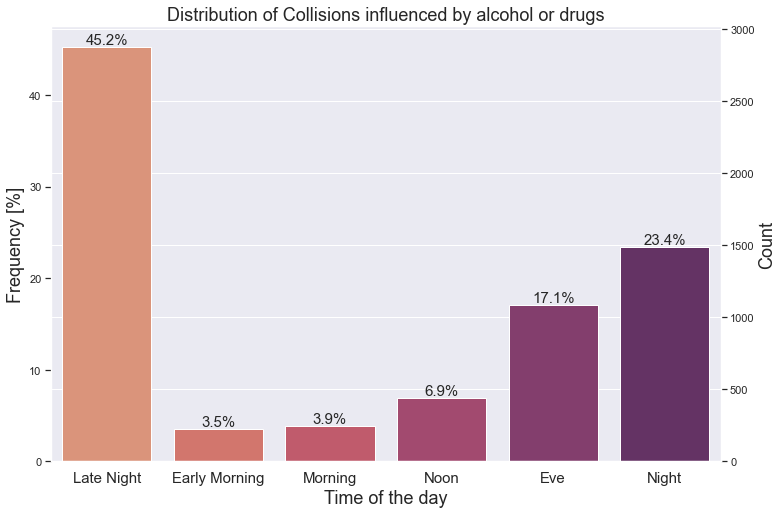

In [68]:
time_of_day_plot(influenced, 'Distribution of Collisions influenced by alcohol or drugs')
plt.savefig('./plots/5.png')

We can see that 45% of the collisions when the influence of alcohol/drugs is present are at **Late Night** and 23% are at **Night**. The behavior is as expected.

Let's study the distribution of the `HITPARKEDCAR` column:

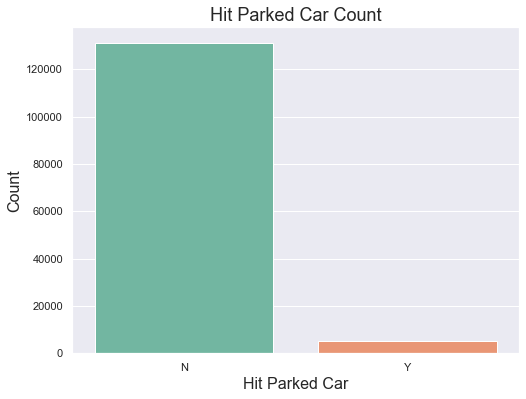

In [69]:
plt.figure(figsize=(8,6))
sns.countplot(x ='HITPARKEDCAR', palette='Set2', data = df) 
plt.title('Hit Parked Car Count', fontsize=18)
plt.xlabel('Hit Parked Car', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('./plots/6.png')

There are few collisions when a parked car is hit. Let's study when more parked cars are hit during the day:

In [70]:
#Filter the dataset with only the rows where HITPARKEDCAR is Y
hit = df['HITPARKEDCAR'] == 'Y'
hit = df[hit]

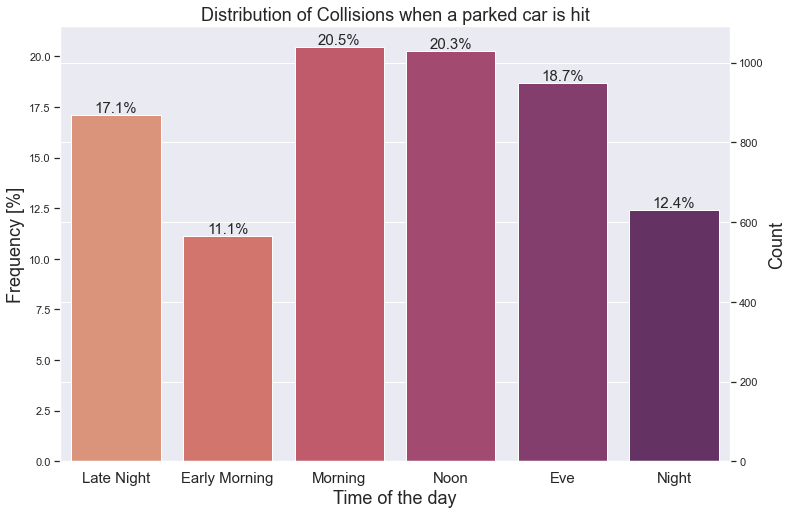

In [71]:
time_of_day_plot(hit, 'Distribution of Collisions when a parked car is hit')
plt.savefig('./plots/7.png')

We can see that 20% of parked cars are hit in the **Morning**, this percentage decreases throughout the day but it suddenly increases in the **Late Night** maybe due to the influence of alcohol and drugs as we have seen.

We can study if people influenced by alcohol/drugs tend to hit parked cars more:

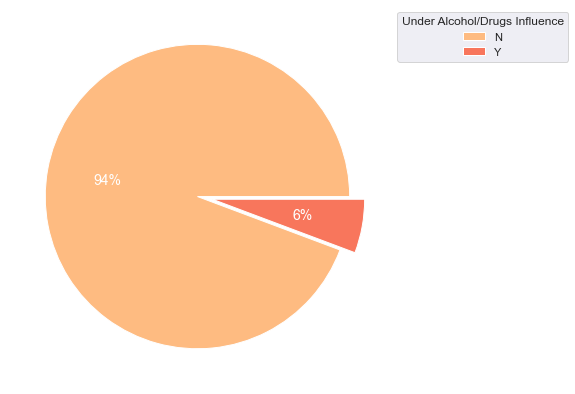

In [72]:
sns.set_palette(sns.color_palette('magma_r'))
tempdf = hit[(hit['UNDERINFL']=='Y')|(hit['UNDERINFL']=='N')]
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(tempdf['UNDERINFL'].value_counts(), textprops={'color':'white', 'fontsize': 14}, autopct='%1.0f%%', explode=[0,0.1])

lgd = ax.legend(tempdf['UNDERINFL'].unique(),
          title='Under Alcohol/Drugs Influence',
          loc='upper center',
          bbox_to_anchor=(1, 0, 0.5, 1))
#plt.savefig('./plots/8.png')
plt.savefig('./plots/8.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

It is observed that most of the parked cars are hit by people with no influence of alcohol/drugs.

Let's study the distribution of collisions when there is influence of alcohol/drugs and a parked car is hit.

In [73]:
#Filter the dataset with only the rows where HITPARKEDCAR is Y and UNDERINFL is Y
hit_infl = (df['HITPARKEDCAR'] == 'Y') & (df['UNDERINFL'] == 'Y')
hit_infl = df[hit_infl]

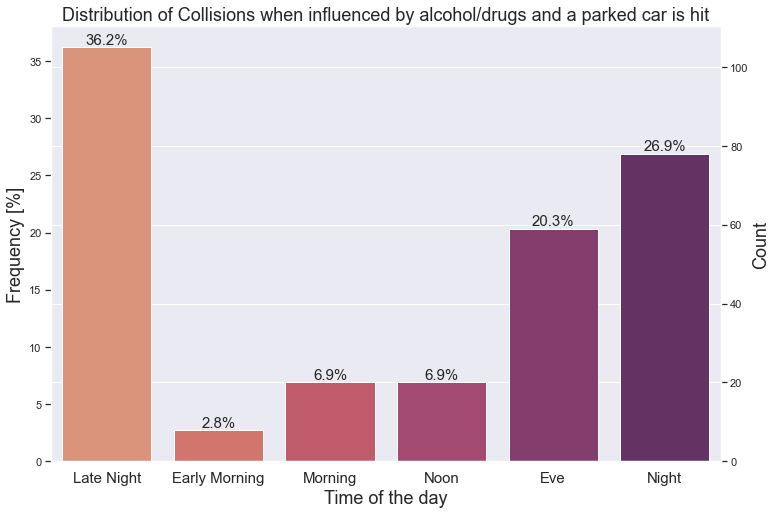

In [74]:
time_of_day_plot(hit_infl, 'Distribution of Collisions when influenced by alcohol/drugs and a parked car is hit')
plt.savefig('./plots/9.png')

We can see that people under the influence of alcohol/drugs tend to hit parked cars at **Late Night**.

Let's create some more plots to see the behavior of the columns left.

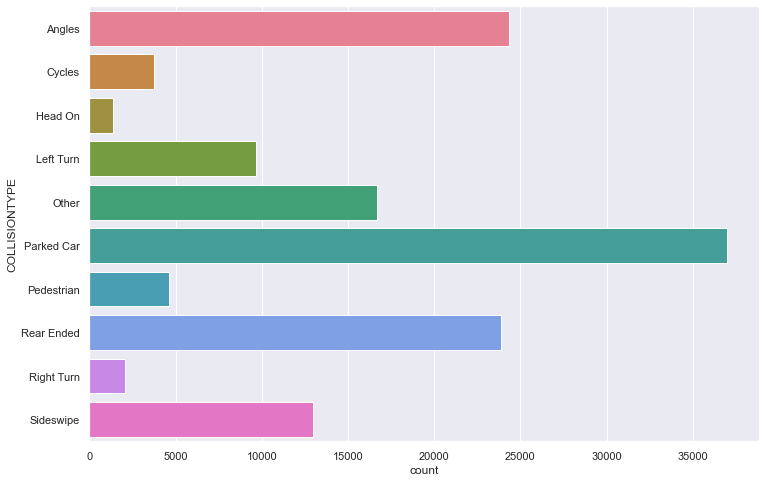

In [75]:
plt.figure(figsize=(12,8))
sns.countplot(y ='COLLISIONTYPE', palette='husl', data = df) 
plt.savefig('./plots/10.png')

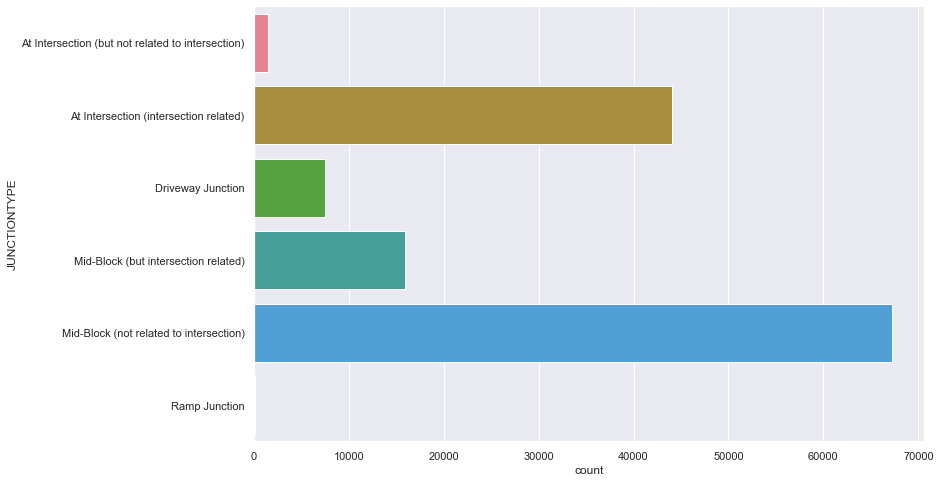

In [76]:
plt.figure(figsize=(12,8))
sns.countplot(y ='JUNCTIONTYPE', palette='husl', data = df)
plt.savefig('./plots/11.png')

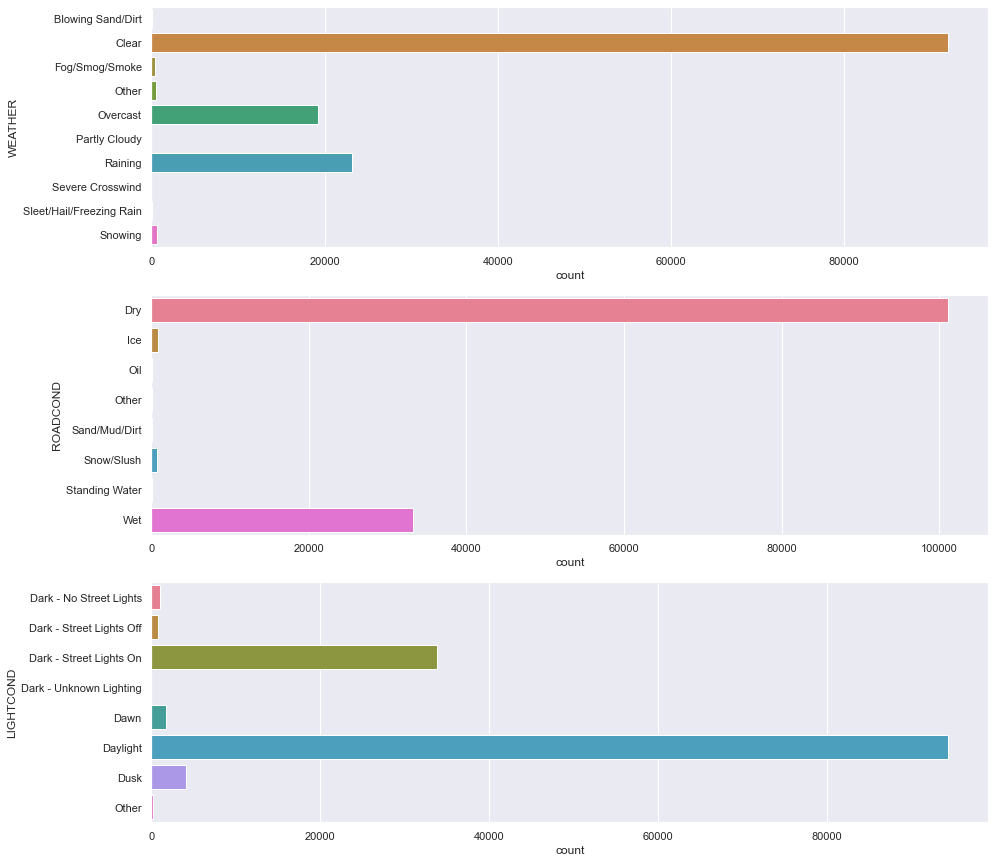

In [77]:
fig, axs = plt.subplots(nrows=3, figsize=(15,15))
sns.countplot(y ='WEATHER', palette='husl', data = df, ax=axs[0]) 
sns.countplot(y ='ROADCOND', palette='husl', data = df, ax=axs[1]) 
sns.countplot(y ='LIGHTCOND', palette='husl', data = df, ax=axs[2])
plt.savefig('./plots/12.png')

We can see that most of the collisions occur when the **Weather** is *Clear* the **Road Condition** is *Dry* and the **Lighting Condition** is *Daylight*.

Let's create a map of Seattle to visualize where the collisions are placed.

*IMPORTANT: the map creation has been commented because it adds several MB to the final notebook*

In [78]:
from folium import plugins

# simply drop whole row with NaN in "price" column
#df_map = df.dropna(subset=['X','Y'], axis=0)

# reset index, because we droped two rows
#df_map.reset_index(drop=True, inplace=True)
 
#latitude = df_map['Y'].mean()
#longitude = df_map['X'].mean()

# let's start with a clean copy of the map of Seattle
#seattle_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the collisions in the dataframe
#collisions = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
#for lat, lng in zip(df_map.Y, df_map.X):
#    folium.Marker(
#        location=[lat, lng],
#        icon=None
#    ).add_to(collisions)

# display map
#seattle_map

We can see that most of the collisions occur in the center of Seattle.

## 4. Pre-processing <a name="pre-processing"></a>

We are going to drop the columns `X` and `Y` as we said earlier. We are also going to drop `INCDTTM` because we have the `TIME` column created earlier:

In [79]:
df.drop(['X','Y','INCDTTM'], axis=1, inplace=True)

In [80]:
df.shape

(136271, 18)

After that, we create X for the features and y for the class:

In [81]:
(X, y) = (df.drop('SEVERITYCODE', axis=1), df['SEVERITYCODE'])

In [82]:
to_encode = ['STATUS', 
             'ADDRTYPE', 
             'COLLISIONTYPE',
             'JUNCTIONTYPE',
             'UNDERINFL',
             'WEATHER',
             'ROADCOND',
             'LIGHTCOND',
             'HITPARKEDCAR',
             'TIME']

le = LabelEncoder()

for feat in to_encode:
    X[feat] = le.fit_transform(X[feat].astype(str))

## 5. Modeling

Then we split the dataset into train and validation:

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

### Decision Tree <a name="descision-tree"></a>

In [84]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
tree_model.fit(X_train, y_train)
predTree = tree_model.predict(X_val)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_val, predTree))

DecisionTrees's Accuracy:  0.7507246376811594


We can plot the generated tree structure:

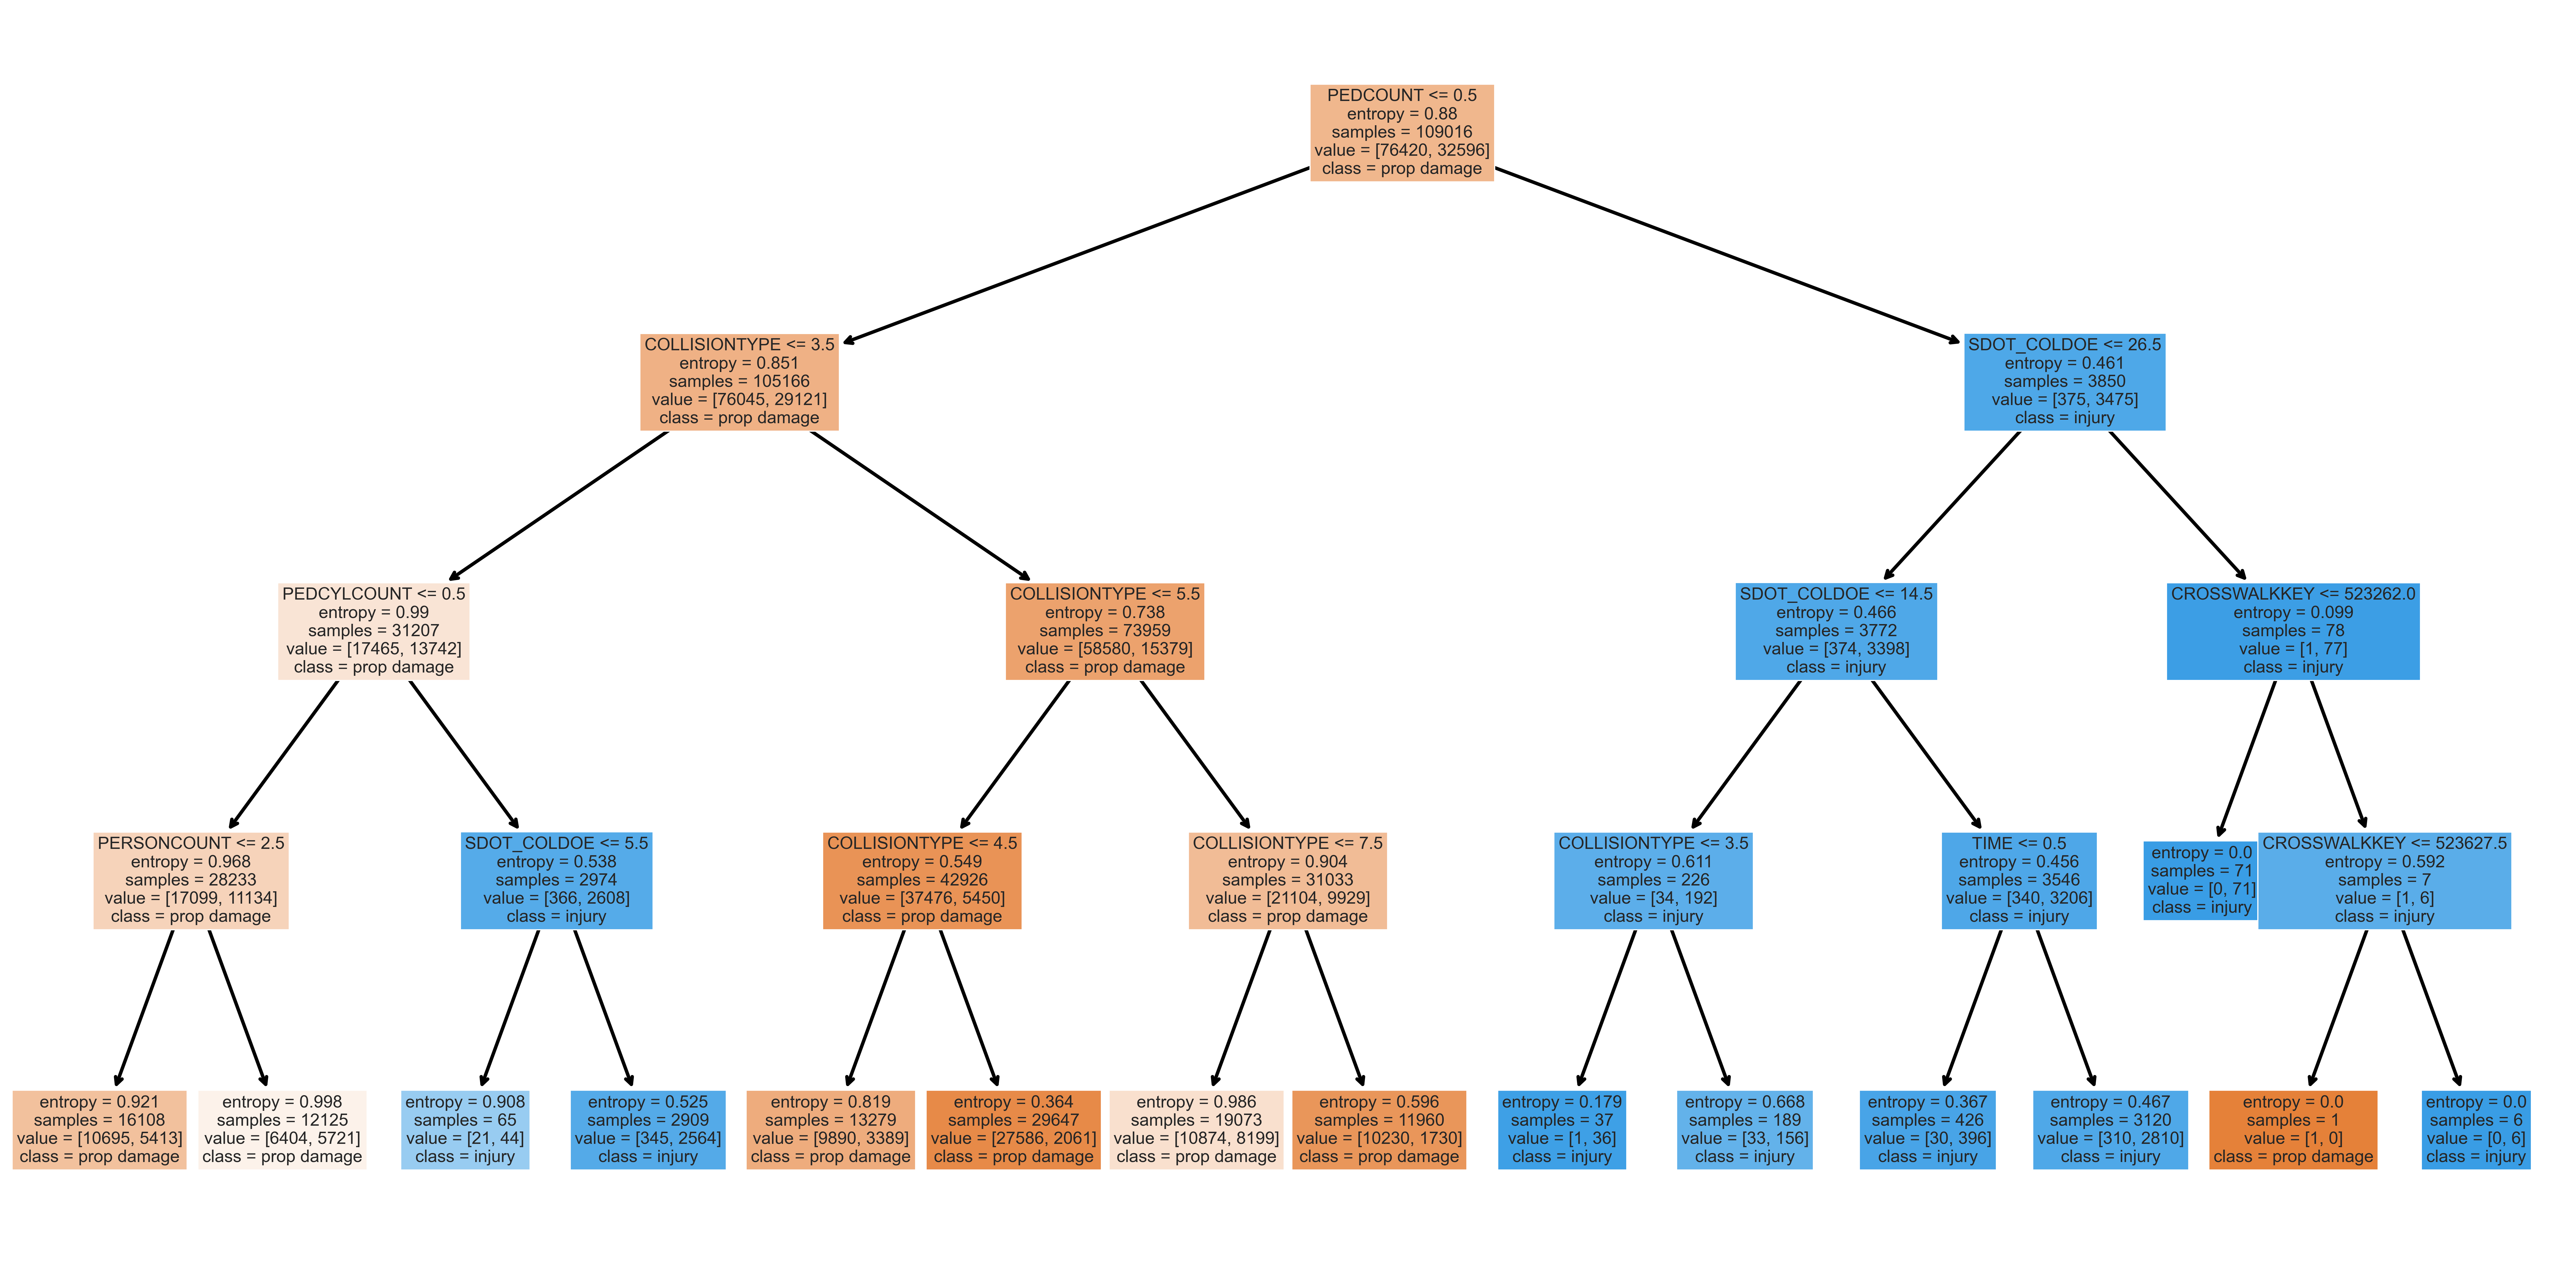

In [85]:
fn=['STATUS','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','SDOT_COLDOE',
   'UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SEGLANEKEY','CROSSWALKKEY','HITPARKEDCAR','TIME']
cn=['prop damage', 'injury']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (40,20), dpi=300)

out = tree.plot_tree(tree_model,
               feature_names = fn, 
               class_names=cn,
               fontsize=15,
               filled = True);

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

plt.savefig('./plots/13.png')

### K Nearest Neighbors <a name="kNN"></a>

In [86]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_val)
    mean_acc[n-1] = metrics.accuracy_score(y_val, yhat)

    
    std_acc[n-1]=np.std(yhat==y_val)/np.sqrt(yhat.shape[0])

mean_acc

array([0.69007522, 0.73032471, 0.71638232, 0.74144194, 0.73105852,
       0.74375344, 0.7396441 , 0.7466153 , 0.74001101, 0.74764263,
       0.74496423, 0.74804623, 0.74489085, 0.74929371, 0.74731242,
       0.74955054, 0.74826637, 0.74918364, 0.74907356])

Plot  model accuracy  for Different number of Neighbors:

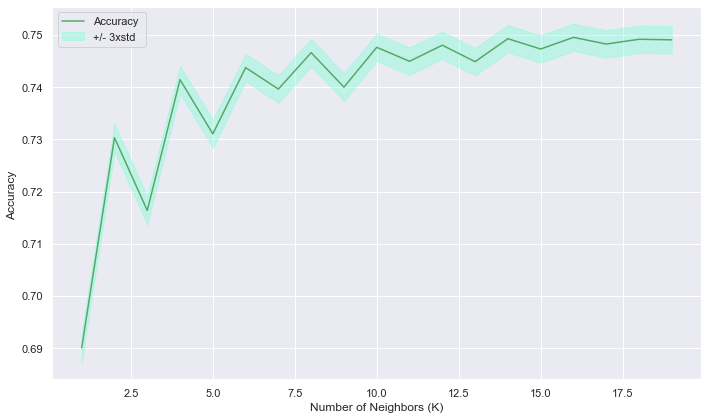

In [87]:
plt.figure(figsize=(10,6))
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.40, color='aquamarine')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.savefig('./plots/14.png')
plt.show()

In [88]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7495505411851037 with k= 16


In [89]:
kNN_model = KNeighborsClassifier(n_neighbors = 16)

### Logistic Regression <a name="LR"></a>

In [90]:
LR_model = LogisticRegression(C=0.01, solver='sag', max_iter=1000)
LR_model.fit(X_train, y_train)
predLR = LR_model.predict(X_val)
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_val,predLR))

Logistic Regression's Accuracy:  0.7280132085855806


C:\Users\namas\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## 5. Model Evaluation <a name="model-evaluation"></a>

We are going to use the test dataset defined earlier: **df_test**
First of all we need to split it into X and y, and apply the transformations that were applied to the training data after the split.

In [91]:
df_test['HOUR'] = df_test['INCDTTM'].dt.hour
bins = [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df_test['TIME'] = pd.cut(df_test['HOUR'], bins=bins, labels=labels, include_lowest=True)
df_test.drop(['HOUR'], axis=1, inplace=True)

df_test.drop(['X','Y','INCDTTM'], axis=1, inplace=True)

(X_test, y_test) = (df_test.drop('SEVERITYCODE', axis=1), df_test['SEVERITYCODE'])

to_encode = ['STATUS', 
             'ADDRTYPE', 
             'COLLISIONTYPE',
             'JUNCTIONTYPE',
             'UNDERINFL',
             'WEATHER',
             'ROADCOND',
             'LIGHTCOND',
             'HITPARKEDCAR',
             'TIME']

le = LabelEncoder()

for feat in to_encode:
    X_test[feat] = le.fit_transform(X_test[feat].astype(str))

Let's define the funtion that plots the confusion matrix we are going to use later:

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

We are going to use all the data from X_train, y_train, X_val, y_val to train the models, therefore we are going to use the variables **X** and **y** which contains the training and validation data. After that we are going to test our models with the test data.

### Decision Tree <a name="decision-tree-eval"></a>

In [93]:
#Train the model on the training data
tree_model.fit(X, y)

#Make predictions on the test data
yhat_tree = tree_model.predict(X_test)

#Compute the different metrics
jaccard_tree = metrics.jaccard_score(y_test, yhat_tree)
f1_tree = metrics.f1_score(y_test, yhat_tree, average='weighted') 
acc_tree = metrics.accuracy_score(y_test, yhat_tree)

#Print the results
print("Tree model Accuracy Score", acc_tree)
print("Tree model Jaccard Score: ", jaccard_tree)
print("Tree model F1 Score: ", f1_tree)

Tree model Accuracy Score 0.7501969110646896
Tree model Jaccard Score:  0.7352028314729104
Tree model F1 Score:  0.6872504254058343


              precision    recall  f1-score   support

           1       0.74      0.99      0.85     40935
           2       0.89      0.19      0.31     17467

    accuracy                           0.75     58402
   macro avg       0.81      0.59      0.58     58402
weighted avg       0.78      0.75      0.69     58402

Confusion matrix, without normalization
[[40506   429]
 [14160  3307]]


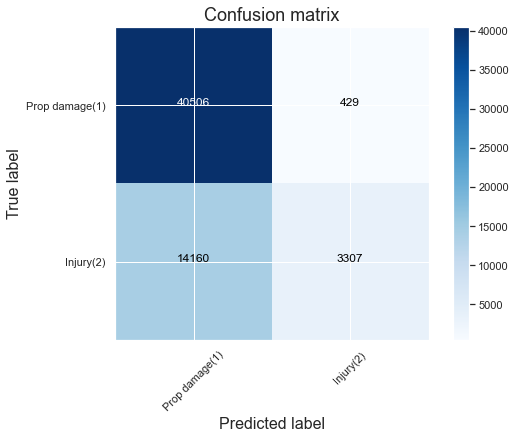

In [94]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_tree, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Prop damage(1)','Injury(2)'],normalize= False,  title='Confusion matrix')
plt.savefig('./plots/15.png')

We can see that our tree model does a good job classifying the **Prop damage** samples, **40506** (TN, if we take the Prop damage class as negative) but its behavior is not good when classifying **Injury** samples, it classifies **14160** samples as **Prop damage** when they really are **Injury** (FN).

### K Nearest Neighbors <a name="kNN-eval"></a>

In [95]:
#Train the model on the training data
kNN_model.fit(X, y)

#Make predictions on the test data
yhat_kNN = kNN_model.predict(X_test)

#Compute the different metrics
jaccard_kNN = metrics.jaccard_score(y_test, yhat_kNN)
f1_kNN = metrics.f1_score(y_test, yhat_kNN, average='weighted') 
acc_kNN = metrics.accuracy_score(y_test, yhat_kNN)

#Print the results
print("K Nearest Neighbors model Accuracy Score", acc_kNN)
print("K Nearest Neighbors model Jaccard Score: ", jaccard_kNN)
print("K Nearest Neighbors model F1 Score: ", f1_kNN)

K Nearest Neighbors model Accuracy Score 0.7499914386493614
K Nearest Neighbors model Jaccard Score:  0.7227465203273645
K Nearest Neighbors model F1 Score:  0.719747580146176


              precision    recall  f1-score   support

           1       0.74      0.99      0.85     40935
           2       0.89      0.19      0.31     17467

    accuracy                           0.75     58402
   macro avg       0.81      0.59      0.58     58402
weighted avg       0.78      0.75      0.69     58402

Confusion matrix, without normalization
[[38062  2873]
 [11728  5739]]


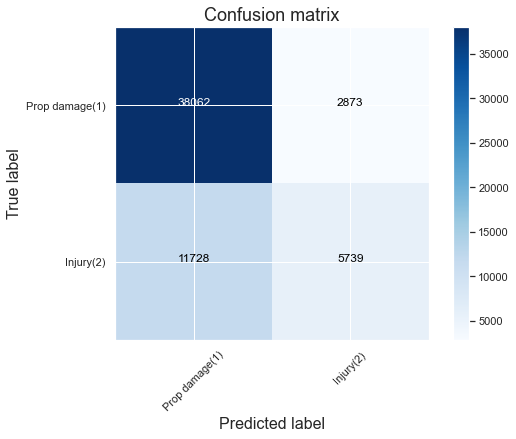

In [96]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_kNN, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Prop damage(1)','Injury(2)'],normalize= False,  title='Confusion matrix')
plt.savefig('./plots/16.png')

We can see that the behavior is similar to the one that the tree model offers, but we can see that the kNN model does a better job classifying the **Injury** class.

### Logistic Regression <a name="LR-eval"></a>

In [97]:
#Train the model on the training data
LR_model.fit(X, y)

#Make predictions on the test data
yhat_LR = LR_model.predict(X_test)
yhat_LR_prob = LR_model.predict_proba(X_test)

#Compute the different metrics
acc_LR = metrics.accuracy_score(y_test, yhat_LR)
jaccard_LR = metrics.jaccard_score(y_test, yhat_LR)
f1_LR = metrics.f1_score(y_test, yhat_LR, average='weighted') 
loss_LR = metrics.log_loss(y_test, yhat_LR_prob)

#Print the results
print("Logistic Regression model Accuracy Score", acc_LR)
print("Logistic Regression model Jaccard Score: ", jaccard_LR)
print("Logistic Regression model F1 Score: ", f1_LR)
print("Logistic Regression mode Log loss ", loss_LR)

Logistic Regression model Accuracy Score 0.7281257491181808
Logistic Regression model Jaccard Score:  0.719460051591929
Logistic Regression model F1 Score:  0.6419365867865238
Logistic Regression mode Log loss  0.6724459461683797


C:\Users\namas\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           1       0.74      0.99      0.85     40935
           2       0.89      0.19      0.31     17467

    accuracy                           0.75     58402
   macro avg       0.81      0.59      0.58     58402
weighted avg       0.78      0.75      0.69     58402

Confusion matrix, without normalization
[[40720   215]
 [15663  1804]]


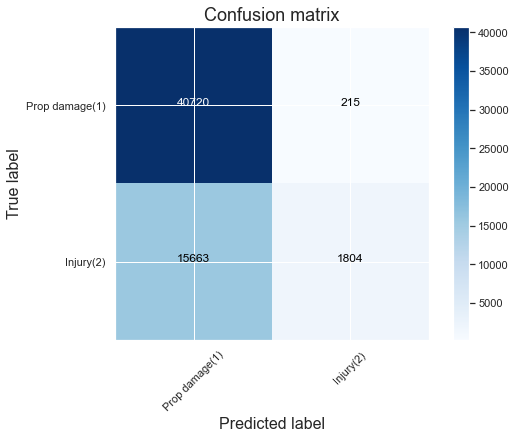

In [98]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LR, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Prop damage(1)','Injury(2)'],normalize= False,  title='Confusion matrix')
plt.savefig('./plots/17.png')

We can see that the behavior is similar to the ones offered by the tree and kNN models but this model is the worst when classifying the **Injury** class.

## 6. Summary <a name="summary"></a>

In [99]:
#Create lists with values
algorithms = ['Decision Tree', 'K Nearest Neighbors', 'Logistic Regression']
acc_total = [acc_tree, acc_kNN, acc_LR]
jaccard_total = [jaccard_tree, jaccard_kNN, jaccard_LR]
f1_total = [f1_tree, f1_kNN, f1_LR]
loss_total = ['','',loss_LR]

#Create the dictionary
d = {'Algorithm':algorithms, 'Accuracy':acc_total, 'Jaccard':jaccard_total, 'F1-score': f1_total, 'LogLoss': loss_total}

#Create and visualize the DataFrame
results = pd.DataFrame(d)
results.set_index('Algorithm', inplace=True)
results

,Accuracy,Jaccard,F1-score,LogLoss
Algorithm,,,,
Decision Tree,0.750197,0.735203,0.687250,
K Nearest Neighbors,0.749991,0.722747,0.719748,
Logistic Regression,0.728126,0.719460,0.641937,0.672446


The model that I would choose is the **K Nearest Neighbors** model since it offers the most balanced predictions out of the three models proposed.